In [208]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.utils import check_array
from sklearn.externals import joblib
import time

In [33]:
#定义MAPE
def mean_absolute_percentage_error(y_true, y_pred): 
    #y_true.reshape(-1)
    #y_pred.reshape(-1)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## 1. 准备数据

In [34]:
df = pd.read_csv('./dataset/2018_dah.csv')

In [35]:
df.head()
#print(len(df))

8761


In [5]:
df['datetime_beginning_ept'] = pd.to_datetime(df['datetime_beginning_ept'])
df['hour'] = df['datetime_beginning_ept'].apply(lambda time : time.hour)
df['month'] = df['datetime_beginning_ept'].apply(lambda time : time.month)
df['dayofweek'] = df['datetime_beginning_ept'].apply(lambda time : time.dayofweek)

In [6]:
Y = np.array(df['total_lmp_da'][24:-1]).reshape((-1, 1))
x_1 = np.array(df['system_energy_price_da'][:-25]).reshape((-1, 1))#system_energy_price
x_2 = np.array(df['marginal_loss_price_da'][:-25]).reshape((-1, 1))#marginal_loss_price
x_3 = np.array(df['congestion_price_da'][:-25]).reshape((-1, 1))#congestion_price
x_4 = np.array(df['total_lmp_da'][:-25]).reshape((-1, 1))#total_lmp_da
x_5 = np.array(df['hour'][24:-1]).reshape((-1, 1))#hour
x_6 = np.array(df['month'][24:-1]).reshape((-1, 1))#month
x_7 = np.array(df['dayofweek'][24:-1]).reshape((-1, 1))#dayofweek
lmp_each_day = np.concatenate((x_1, x_2, x_3), axis=1).reshape((-1, 72))

In [7]:
X = []
for i in range(364):
    for j in range(24):
        idx = (i + 1) * (j + 1) - 1
        X.append(lmp_each_day[i])
X = np.array(X)
X = np.concatenate((X, x_4, x_5, x_6, x_7), axis=1)

### 归一化

In [11]:
X = preprocessing.scale(X)
#print(X.shape)

(8736, 76)


In [52]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2)
#print(x_train.shape, x_val.shape, x_test.shape)
para = pd.DataFrame(columns=['C', 'gamma', 'mae', 'mape', 'time'])

(6289, 76) (1573, 76) (874, 76)


## 2. SVR模型

In [40]:
start = time.time()
C = 225
gamma = 0.5
svr = SVR(cache_size=2000, kernel='rbf', C = C, gamma=gamma)
svr.fit(x_train, y_train)
end = time.time()
print('Finished in: %dmin %ds' % ((end - start) // 60, (end - start) % 60))

pre_val = svr.predict(x_val).reshape((-1, 1))
mae = mean_absolute_error(y_val, pre_val)
mape = mean_absolute_percentage_error(y_val, pre_val)
print('MAE:', mae)
print('MAPE:', mape)
para.loc[len(para)] = [C.round(1), gamma.round(2), mae.round(4), mape.round(4), (end - start).round(1)]

C:\Users\mohan\Anaconda3\envs\ML\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Finished in: 0min 28s
MAE: 2.079849017819433
MAPE: 5.463943550389919


,C,gamma,mae,mape,time
0,10.0,0.01,4.317672,11.205720,13.232554
1,10.0,0.10,3.713516,8.683343,13.792140
2,10.0,1.00,4.872499,8.123310,17.395375
3,100.0,1.00,2.624364,5.972163,56.557901
4,200.0,1.00,2.399090,5.933932,97.820884
5,300.0,1.00,2.415230,6.078369,149.473835
6,250.0,1.00,2.418047,6.004587,50.238602
7,225.0,1.00,2.408960,5.964324,44.235149
8,225.0,2.00,3.006485,7.086714,70.060119
9,225.0,1.50,2.746244,6.559714,58.217384


In [214]:
#保存调参数据
para.to_csv('svr.csv')
para.head(100)
#保存模型
joblib.dump(svr, 'model_output/svr.pkl')

['model_output/svr.pkl']

MAE: 2.153290967025051
MAPE: 5.223155105940737


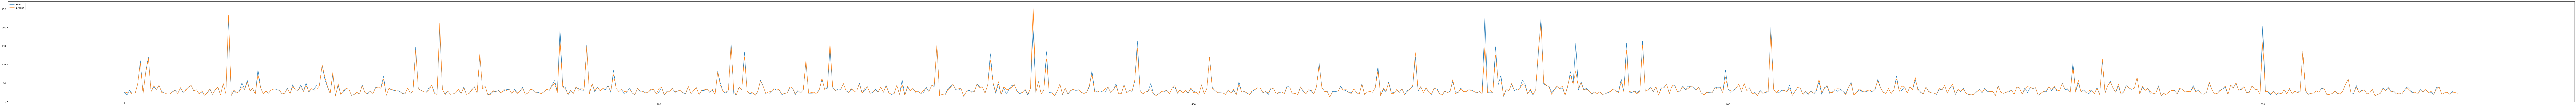

In [47]:
#进行预测，做出预测曲线
pre = svr.predict(x_test).reshape((-1, 1))
print('MAE:', mean_absolute_error(y_test, pre))
print('MAPE:', mean_absolute_percentage_error(y_test, pre))

size = len(y_test)
plt.figure(figsize = (200, 8), dpi = 80)
plt.plot(range(size), y_test[:size], label = 'real')
plt.plot(range(size), pre[:size], label = 'predict')
plt.legend(loc = 'upper left')
plt.savefig('svr')

## 3. MLP模型

In [154]:
import keras
from keras.models import Sequential
from keras.layers.core import Dense

In [203]:
model = Sequential()
model.add(Dense(64,  activation='relu', input_shape = (76, )))
model.add(Dense(16, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='linear'))

In [204]:
model.compile(loss=keras.losses.mean_absolute_error, optimizer=keras.optimizers.adagrad(lr=0.1), metrics=['mean_absolute_error'])

In [205]:
start = time.time()

model.fit(x_train, y_train, batch_size=60, epochs=1000, verbose=1, validation_data=(x_val, y_val))
score = model.evaluate(x_test, y_test)
pre = model.predict(x_test)
end = time.time()
print('Finished in: %dmin %ds' % ((end - start) // 60, (end - start) % 60))

Train on 6289 samples, validate on 1573 samples
Epoch 1/1000
6289/6289 [==============================] - 2s 333us/step - loss: 10.0780 - mean_absolute_error: 10.0780 - val_loss: 6.1174 - val_mean_absolute_error: 6.1174
Epoch 2/1000
6289/6289 [==============================] - 0s 73us/step - loss: 6.3156 - mean_absolute_error: 6.3156 - val_loss: 5.2279 - val_mean_absolute_error: 5.2279
Epoch 3/1000
6289/6289 [==============================] - 0s 71us/step - loss: 5.5385 - mean_absolute_error: 5.5385 - val_loss: 5.1855 - val_mean_absolute_error: 5.1855
Epoch 4/1000
6289/6289 [==============================] - 0s 72us/step - loss: 5.2694 - mean_absolute_error: 5.2694 - val_loss: 4.4825 - val_mean_absolute_error: 4.4825
Epoch 5/1000
6289/6289 [==============================] - 0s 71us/step - loss: 5.0421 - mean_absolute_error: 5.0421 - val_loss: 4.4358 - val_mean_absolute_error: 4.4358
Epoch 6/1000
6289/6289 [==============================] - 0s 71us/step - loss: 4.9494 - mean_absolute_er

In [ ]:
#保存模型
model.save('./model_output/mlp.h5')

MAE: 2.6470194070672006
MAPE: 6.938787566147152


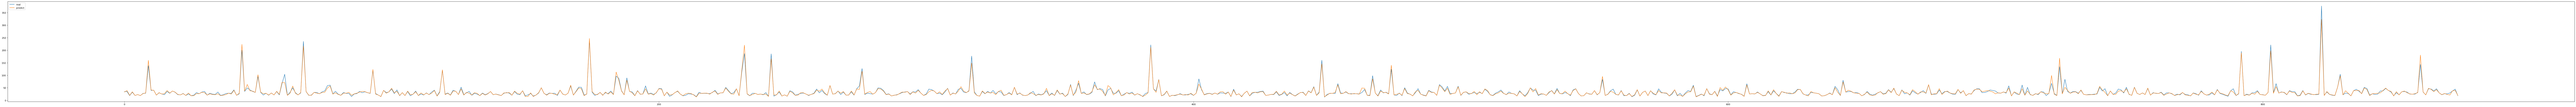

In [213]:
#进行预测，做出预测曲线
print('MAE:', mean_absolute_error(y_test, pre))
print('MAPE:', mean_absolute_percentage_error(y_test, pre))
size = len(y_test)
plt.figure(figsize = (200, 8), dpi = 80)
plt.plot(range(size), y_test[:size], label = 'real')
plt.plot(range(size), pre[:size], label = 'predict')
plt.legend(loc = 'upper left')
plt.savefig('mlp')